In [1]:
library(tidyverse)
theme_set(theme_classic())
options(repr.plot.width  = 10, repr.plot.height = 6)
set.seed(1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# STATS 504
## Survival Analysis II 

In [21]:
library(tidyverse)
library(survival)
library(survminer)
library(gtsummary)

## Proportional hazards regression
- The K-M estimator is _non-parametric_; it estimates a whole function without assuming any model.
- If we want to be able to interpret the effect of different covariates on survival, we need a model which relates
the covariates to the outcome (lifespan).
    - We are going to model the hazard rate function directly. 
    - The approach we will use is similar to how we used generalized linear modeling to allow differences in the mean parameter for various distributions.

### The Cox model
- Let $\mathbf{Z}$ be a vector of individual-specific covariates.
- The proportional hazards model assumes that $$h(t\mid \mathbf{Z}) = h_0(t)c(\beta^\intercal \mathbf{Z}),$$ where $h_0$ is an unknown baseline hazard rate and $\mathbf{Z}\in\mathbb{R}^p$ is a vector of predictors.
- $c(\cdot)$ is analagous to the link function in GLM. 
- The natural choice is $c=\exp$, leading to the famous Cox model.

### Interpretation
- Let $S_0(t)=\exp(-\int_0^t h_0(s)\,ds)$ be the baseline survival function.
- Then $$S(t\mid \mathbf{Z}) = \exp\left(-\int_0^t h(s\mid \mathbf{Z})\,ds\right) = S_0(t)^{e^{\mathbf{Z}^\intercal \beta}}$$
- Additionally, $\log h(t\mid\mathbf{Z}) = \log h_0(t) + \mathbf{Z}^\intercal \beta$, so $\log h_0(t)$ is a sort of intercept term.
- The Cox model is essentially a multiple linear regression of the log hazard on covariates. 
- This is known as a **semi-parametric** model: there is a parametric (finite dimensional) component $\beta$ as well as an infinite dimensional parameter $h_0(t)$.

### Proportional hazards property
As already remarked, the Cox model has the proportional hazards property:
   - Let $\mathbf{Z},\mathbf{Z}^*$ be covariates for two different patients.
   - Then $$\frac{h(t\mid\mathbf{Z})}{h(t\mid\mathbf{Z}^*)} = \exp[\beta(\mathbf{Z}-\mathbf{Z}^*)],$$ i.e. it is constant over time.
   - In particular, if there is a single treatment effect $\beta$, the hazard ratio is $e^\beta$, similar to logistic regression.

## Estimating the proportional hazards model
- Estimation is complicated by the fact that part of the model $h_0(t)$ is infinite dimensional.
- Cox's brilliant insight was that it is possible to estimate $\beta$ in spite of this!
- To overcome this we use a technique called *partial likelihoods*.
    - Say we observe deaths at times $t_1,\dots,t_D$.
    - The person who died at time $t_i$ is denoted "person $i$" and has covariates $\mathbf{Z}_i$.  (As usual, we assume no ties.)
    - Assuming no ties and independence between the life spans, we have
$$\mathbb{P}(\text{data}) = \prod_{i=1}^D \underbrace{\mathbb{P}(\text{person $i$ died}\mid\text{somebody died at $t_i$})}_\text{(I)} \underbrace{\mathbb{P}(\text{somebody died at $t_i$})}_\text{(II)}$$
    - Term (I) is simply the softmax function which we studied in multinomial logit: $$\frac{\exp(\mathbf{Z}_i^\intercal \beta)}{\sum_{j\in R(t_i)} \exp(\mathbf{Z}_j^\intercal \beta)}.$$ Here, the summation is over the set $R(t_i)$ of people who are at risk at time $t_i$.


## The partial likelihood
- The partial likelihood is formed by considering the product of term (I) only. That is, we condition on the observed death times $t_1,\dots,t_D$ and do not use them for inference: $$L(\beta) = \prod_i \frac{\exp(\mathbf{Z}_i^\intercal \beta)}{\sum_{j\in R(t_i)} \exp(\mathbf{Z}_j^\intercal \beta)}.$$

## The MPLE
- To fit the partial likelihood we maximize $\text{LL}(\beta)=\log L(\beta)$ with respect to $\beta$, obtaining the *maximum partial likelihood estimator* (MPLE).
- This can be accomplished by setting the score functions $$U_h = \frac{\partial \log L(\beta)}{\beta_h}=\sum_{i=1}^D Z_{ih} - \frac{\sum_{j\in R(t_i)} Z_{jh} \exp(\mathbf{Z}_j^\intercal \beta)}{\sum_{j\in R(t_i)} \exp(\mathbf{Z}_j^\intercal \beta)}$$ to zero.

## Fitting the proportional hazards model
The command ``coxph`` is used to fit the Cox model in R.

### Interpreting the Cox model

Similar to logistic regression:

- A negative coefficient estimator means the hazard decreases with increasing values of the variable.
- A one-unit increase in covariate causes the hazard ratio to increase/decrease by $\exp(\beta)$

### Assumptions of the Cox model

- Hazards are actually proportional!
- Covariates and coefficients do not depend on time.
- Log hazard is a linear function of the covariates.

## A complete survival analysis 
- Let's walk through a complete survival analysis using K-M.

In [20]:
help(lung)
head(lung)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,306,2,74,1,1,90,100,1175,NA
2,3,455,2,68,1,0,90,90,1225,15
3,3,1010,1,56,1,0,90,90,NA,15
4,5,210,2,57,1,1,90,60,1150,11
5,1,883,2,60,1,0,100,90,NA,0
6,12,1022,1,74,1,1,50,80,513,0


In [22]:
d_lung <- survival::lung %>%
  filter(!is.na(ph.ecog)) %>%
  mutate(
    ph.ecog = factor(
      ph.ecog,
      levels = c(0, 1, 2, 3, 4),
      labels = c("Asymptomatic", "Ambulatory", "In bed <50%", "In bed >50%", "Bedridden")),
    ph.ecog = fct_drop(ph.ecog),
    ph.ecog = fct_lump_n(ph.ecog, n = 2, other_level = "Bedridden"),
    sex = factor(sex, levels = c(1, 2), labels = c("Male", "Female")),
    age_bin = cut(age, breaks = c(38, 55, 65, 83)),
    patient_id = row_number()
  )

In [23]:


(m_fit <- survfit(Surv(time, status) ~ ph.ecog, data = d_lung))

Call: survfit(formula = Surv(time, status) ~ ph.ecog, data = d_lung)

                       n events median 0.95LCL 0.95UCL
ph.ecog=Asymptomatic  63     37    394     348     574
ph.ecog=Ambulatory   113     82    306     268     429
ph.ecog=Bedridden     51     45    183     153     288

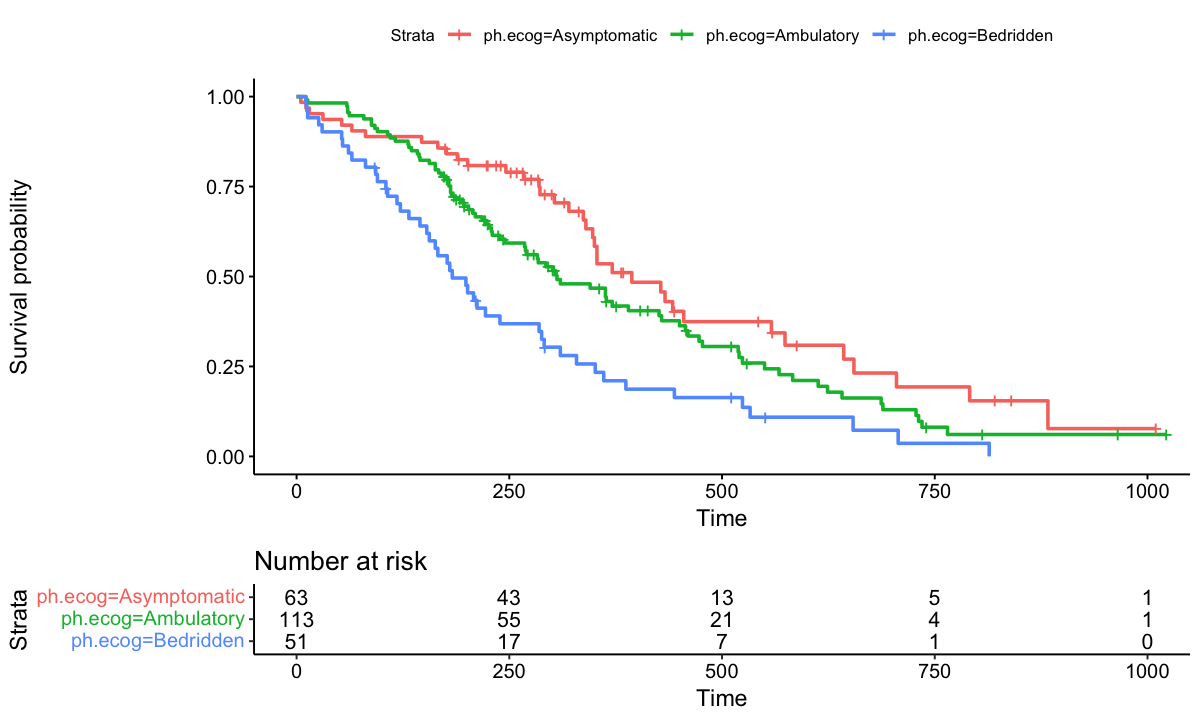

In [24]:
ggsurvplot(m_fit, risk.table = TRUE)

Call: survfit(formula = Surv(time, status) ~ sex, data = d_lung)

             n events median 0.95LCL 0.95UCL
sex=Male   137    111    270     218     320
sex=Female  90     53    426     348     550

Warning message in .add_surv_median(p, fit, type = surv.median.line, fun = fun, :
“Adding survival median lines is not allowed when fun is: cumhaz”


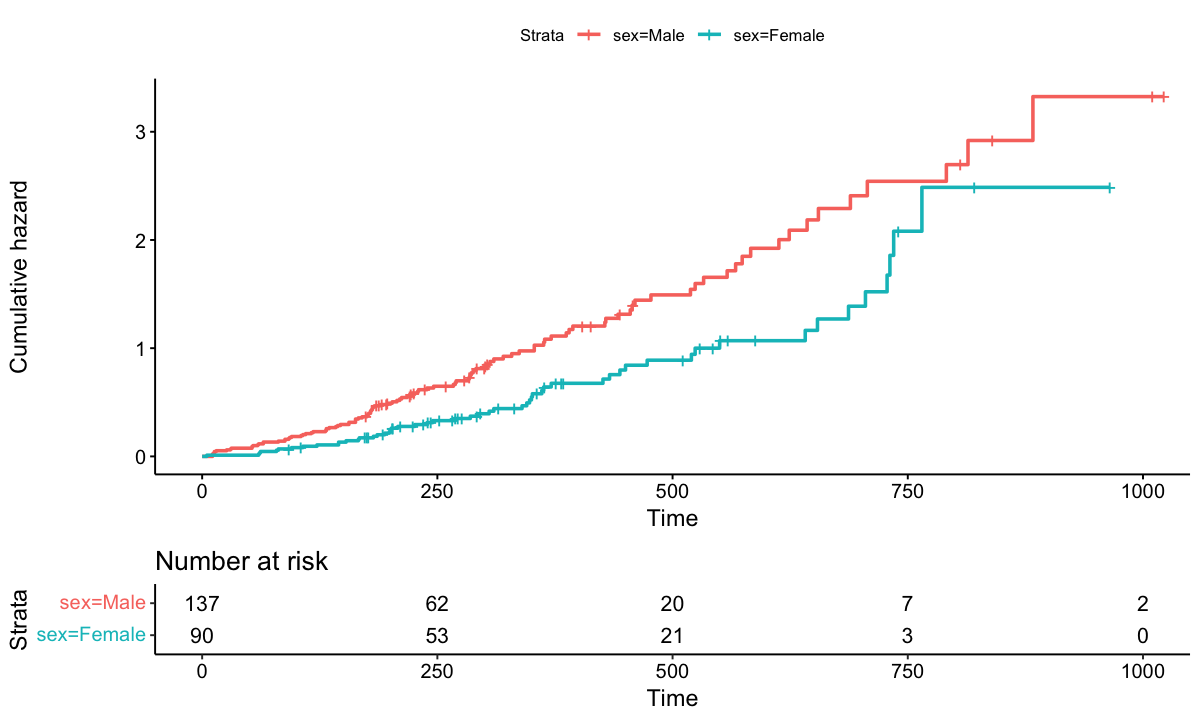

In [25]:
(km_fit <- survfit(Surv(time, status) ~ sex, data = d_lung))
ggsurvplot(km_fit, risk.table = TRUE, surv.median.line = "hv", fun = "cumhaz")

## Testing for differences in survival

- How can we test whether there is a significant difference in survival between different groups?
- Idea: $$H_0: h_0(t) = h_1(t)$$ versus $$H_1: h_0(t) = \lambda h_1(t)$$ for some $\lambda\neq 1$.
- Under $H_0$, appropriate test statistic has approximately Normal(0,1) distribution.

In [26]:
(km_diff <- survdiff(Surv(time, status) ~ sex, data = d_lung))

Call:
survdiff(formula = Surv(time, status) ~ sex, data = d_lung)

             N Observed Expected (O-E)^2/E (O-E)^2/V
sex=Male   137      111       91      4.42        10
sex=Female  90       53       73      5.50        10

 Chisq= 10  on 1 degrees of freedom, p= 0.002 

In [27]:
(km_diff <- survdiff(Surv(time, status) ~ ph.ecog, data = d_lung))

Call:
survdiff(formula = Surv(time, status) ~ ph.ecog, data = d_lung)

                       N Observed Expected (O-E)^2/E (O-E)^2/V
ph.ecog=Asymptomatic  63       37     54.2    5.4331    8.2119
ph.ecog=Ambulatory   113       82     83.5    0.0279    0.0573
ph.ecog=Bedridden     51       45     26.3   13.2582   15.9641

 Chisq= 19  on 2 degrees of freedom, p= 8e-05 

How about comparing the median time to survival?

In [28]:
surv_median(km_fit)

strata,median,lower,upper
<chr>,<dbl>,<dbl>,<dbl>
sex=Male,270,218,320
sex=Female,426,348,550


### Survival of baseball players

- "The Longevity of Baseball Hall of Famers Compared to Other Players", Abel and Kruger (2005).
- Using a Cox proportional hazards model, found that median survival after being inducted into the Hall of Fame was 5 years shorter than for noninducted players (18 vs. 23 years, respectively).


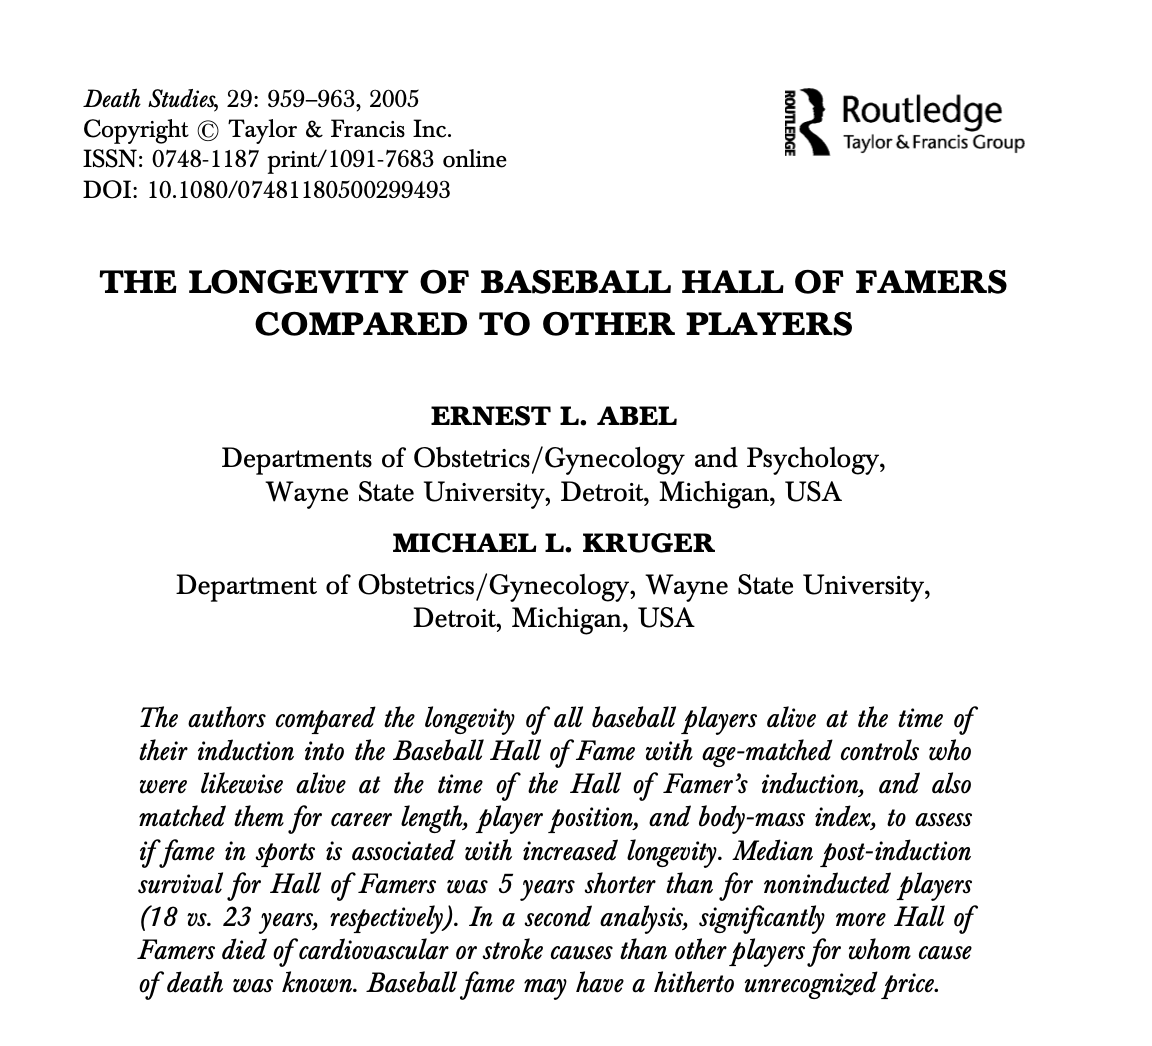

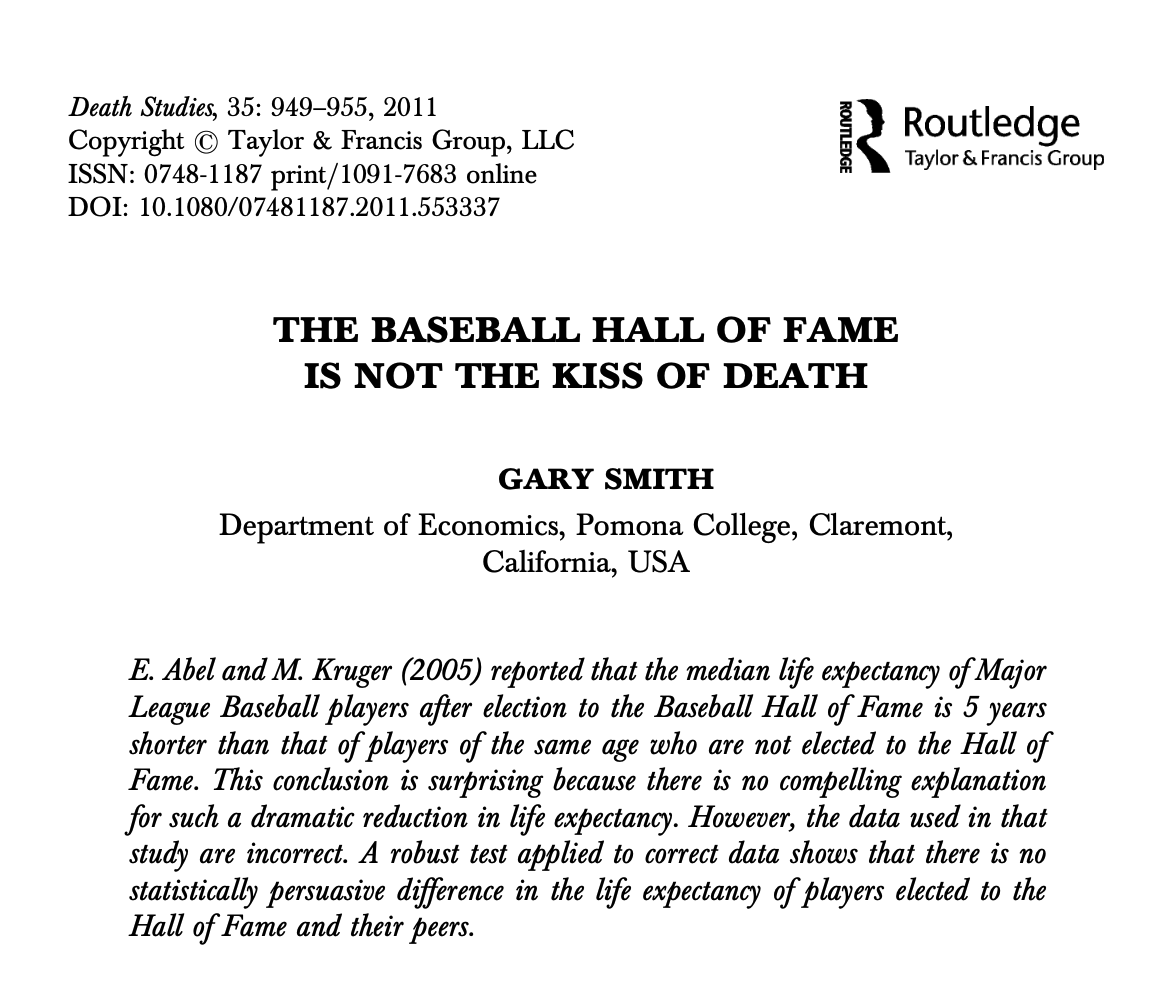

In [76]:
library(Lahman)
HallOfFame %>% head

,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,needed_note
,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<chr>
1,cobbty01,1936,BBWAA,226,170,222,Y,Player,NA
2,ruthba01,1936,BBWAA,226,170,215,Y,Player,NA
3,wagneho01,1936,BBWAA,226,170,215,Y,Player,NA
4,mathech01,1936,BBWAA,226,170,205,Y,Player,NA
5,johnswa01,1936,BBWAA,226,170,189,Y,Player,NA
6,lajoina01,1936,BBWAA,226,170,146,N,Player,NA


In [82]:
xtabs(~  category + inducted, data = HallOfFame)

                   inducted
category               N    Y
  Manager             51   23
  Pioneer/Executive    7   37
  Player            3925  270
  Umpire               0   10

In [85]:
People %>% colnames

[1] "playerID"     "birthYear"    "birthMonth"   "birthDay"     "birthCountry"
 [6] "birthState"   "birthCity"    "deathYear"    "deathMonth"   "deathDay"    
[11] "deathCountry" "deathState"   "deathCity"    "nameFirst"    "nameLast"    
[16] "nameGiven"    "weight"       "height"       "bats"         "throws"      
[21] "debut"        "finalGame"    "retroID"      "bbrefID"      "deathDate"   
[26] "birthDate"

In [14]:
HallOfFame %>% left_join(People) %>% 
    filter(deathYear > yearID | is.na(deathYear)) %>% 
    mutate(
        event = !is.na(deathYear),
        life_after_vote = ifelse(event, deathYear - yearID, 2024 - yearID)
    ) %>% 
    select(birthYear, yearID, deathYear, life_after_vote, event, category, inducted) ->
    bb_surv

Joining with `by = join_by(playerID)`


In [15]:
survfit(Surv(life_after_vote, event) ~ inducted + category, data = bb_surv) %>% print #ggsurvplot

Call: survfit(formula = Surv(life_after_vote, event) ~ inducted + category, 
    data = bb_surv)

   5 observations deleted due to missingness 
                                          n events median 0.95LCL 0.95UCL
inducted=N, category=Executive           25     20    7.0       5      11
inducted=N, category=Manager             90     78   23.0      19      26
inducted=N, category=Pioneer/Executive    7      7   17.0      13      NA
inducted=N, category=Player            4203   2961   27.0      26      27
inducted=N, category=Umpire              30     29    8.0       7      10
inducted=Y, category=Executive            7      4    9.0       8      NA
inducted=Y, category=Manager             16     12   15.5       9      NA
inducted=Y, category=Player             209    135   23.0      17      26
inducted=Y, category=Umpire               6      6    8.0       6      NA


In [16]:
cox_model <- coxph(Surv(life_after_vote, event) ~ inducted + category, data = bb_surv)
summary(cox_model)

Call:
coxph(formula = Surv(life_after_vote, event) ~ inducted + category, 
    data = bb_surv)

  n= 4593, number of events= 3252 
   (5 observations deleted due to missingness)

                              coef exp(coef) se(coef)      z Pr(>|z|)    
inductedY                  0.27054   1.31067  0.08252  3.278  0.00104 ** 
categoryManager           -1.19022   0.30415  0.23125 -5.147 2.65e-07 ***
categoryPioneer                 NA        NA  0.00000     NA       NA    
categoryPioneer/Executive -0.47453   0.62218  0.43024 -1.103  0.27005    
categoryPlayer            -1.57373   0.20727  0.20694 -7.605 2.85e-14 ***
categoryUmpire             0.40009   1.49196  0.26511  1.509  0.13126    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                          exp(coef) exp(-coef) lower .95 upper .95
inductedY                    1.3107     0.7630    1.1149    1.5408
categoryManager              0.3042     3.2878    0.1933    0.4786
categoryPioneer                  N

## Machine learning methods in survival analysis

- We have studied three ways of estimating survival:
    - Nonparametric (Kaplan-Meier):
        - Pros: no assumptions about the survival distribution.
        - Cons: cannot accomodate covariates.
    - Semi-parametric (Cox regression):
        - Pros: allows covariates; somewhat interpretable.
        - Cons: proportional hazards assumption may not be realistic.
    - Parametric (Weibull / log-logistic / etc. regression)
        - Pros: very interpretable. straightforward theory.
        - Cons: too simplistic in some cases.

### Random survival forests
- Today we will look at a technique, random survival forests (RSF), that tries to combine the strengths of these three approaches.
- We will estimate the cumulative hazard function $\hat{H}(t)$ (aka CHF) in a way that
    - Places minimal assumptions on the true function $H(t)$, 
    - Can depend on covariates, and is
    - (somewhat) interpretable 

### Bagging
- Bagging stands for "bootstrap aggregation".
- Suppose we have training data $\mathbf{Z}=\{(x_1,y_1),\dots,(x_N,y_N)\}$. Using whatever method, we obtain a prediction function $\hat{y}=\hat{f}(x\mid\mathbf{Z})$.
- Now suppose instead of fitting one training function, we form bootstrap replicates $\mathbf{Z}^*_1,\dots,\mathbf{Z}^*_B$ from the training data and use each to form a prediction function $$\hat{f}(x\mid \mathbf{Z}^*_b),\quad b=1,\dots,B.$$
- The "bagged" prediction function is $$\hat{f}^*(x\mid\mathbf{Z}) = \frac{1}{B}\sum_b \hat{f}(x\mid \mathbf{Z}_b^*)=\frac{1}{B}\sum_b \hat{f}_b(x)$$

### Why bagging works
- Let the true distribution of the the $x_i$ be denoted $\mathcal{P}$.
- The true regression function is $f(x)$, so that $\hat{f}_b(x)=f(x)+\epsilon_b(x)$.
- The average error of the un-bagged predictors is $$E_\text{avg} = \frac{1}{B} \mathbb{E}_x\left\{[\hat{f}_b(x)-f(x)]^2\right\}=\frac{1}{B}\sum_b\mathbb{E}_x[\epsilon_b(x)^2].$$

- If the errors are zero-mean, variance $\sigma^2$ and $\rho=\operatorname{cor}[\epsilon_i(x),\epsilon_j(x)]$ then
he average error of the bagged regression function is $$E_\text{bag}=\mathbb{E}_x \left\{\left[ \frac{1}{B} \sum_b \epsilon_b(x)\right]^2 \right\} = \rho \sigma^2 + \frac{1-\rho}{B}\sigma^2$$
- In particular, if $\rho=0$ then  $E_\text{bag} = E_\text{avg}/ B$.
- Goal is to make $\rho$ small. This is what RF tries to achieve by randomly subsetting the predictors over which splits are computed.

### The random survival forest algorithm
1. Draw $B$ bootstrap samples from the data. For each sample, record also the OOB (out-of-bag) portion of the sample.
2. Grow a survival tree for each bootstrap sample. Keep growing until all terminal nodes have no less than $d_0>0$ unique deaths.
3. Calculate a CHF for each tree. Average to obtain the ensemble CHF.

## Understanding variable importance
- Ensemble methods can be difficult to interpret.
- The authors suggest the following measure of variable importance: 
    - Drop the OOB cases on each tree. Each time the focal predictor $X$ is encountered in a decision rule, pick a random branch.
    - Variable importance is defined as the difference in prediction error between this and the ensemble prediction.

In [171]:
# install.packages("randomForestSRC")

library(randomForestSRC)

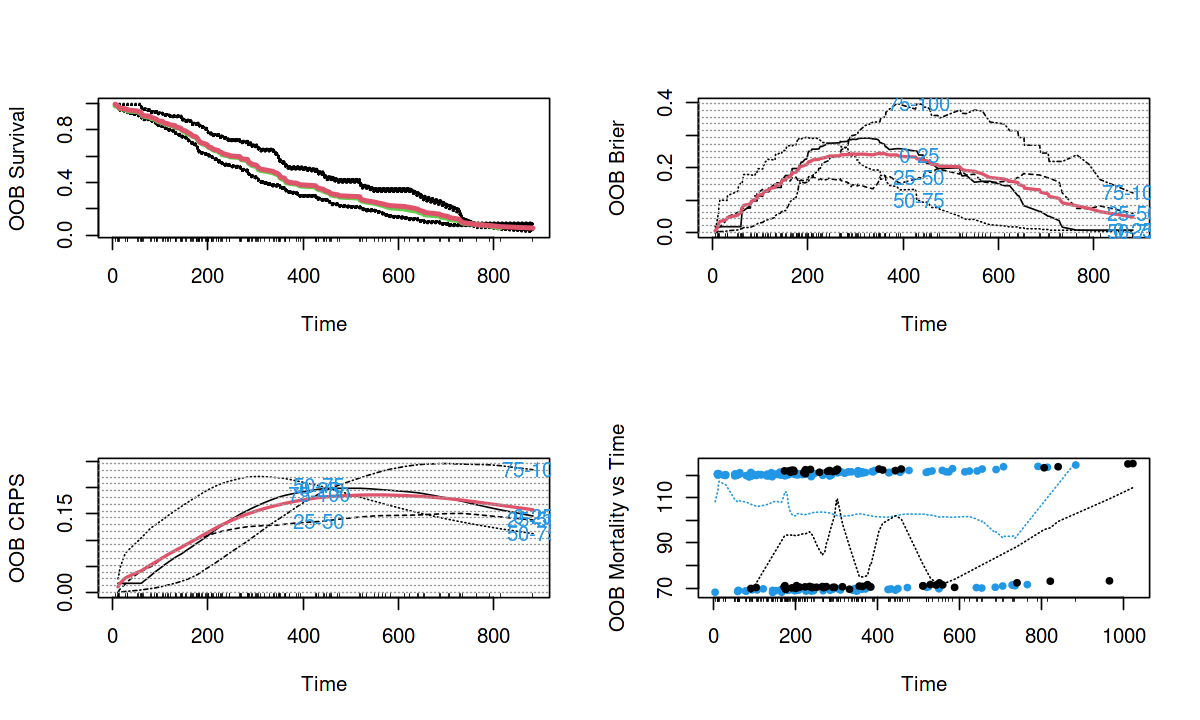

In [179]:
library(randomForestSRC)
d_lung %>% mutate(status = status - 1) %>% 
    rfsrc(Surv(time, status) ~ sex, data = .) %>% 
    plot.survival(show.plots = 1)

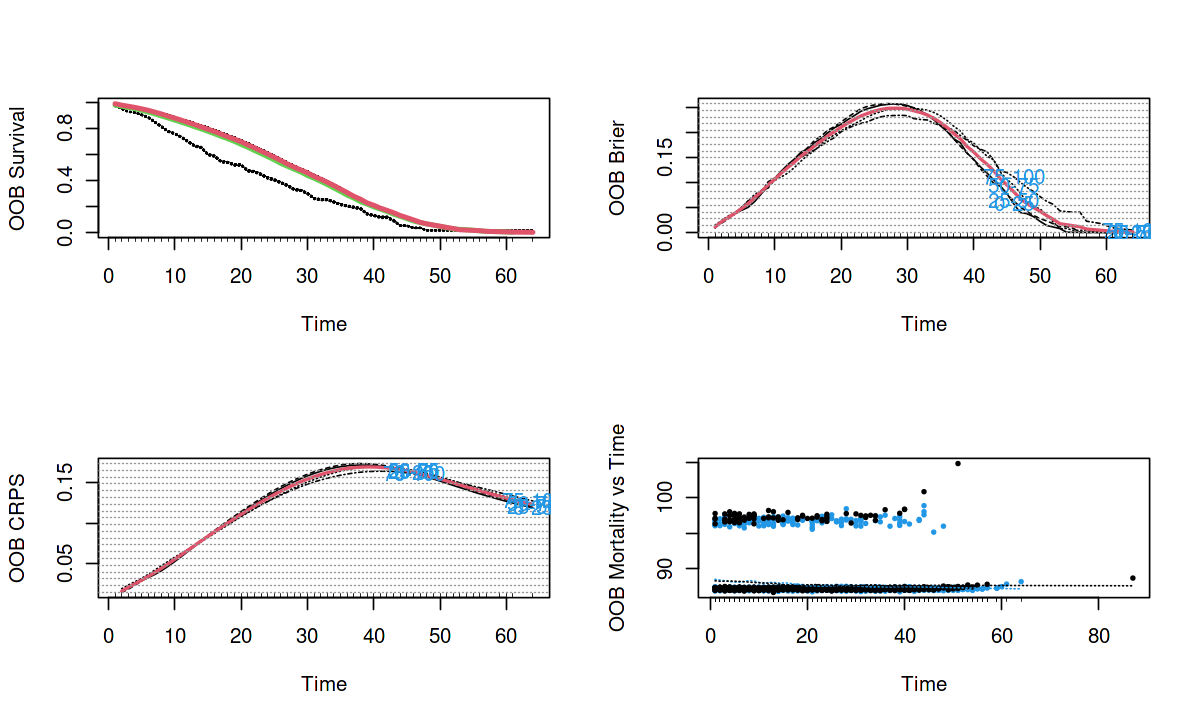

In [189]:
rf_fit <- rfsrc(Surv(life, event) ~ inducted, data = hof_surv)

plot.survival(rf_fit)